# **Validation of Dataset for Defaulter Prediction Based on Customer Behavior**

### **Introduction**

Given a dataset of the past consumer loans, the potential defaulters should be predicted. The dataset is from Kaggle 

### **Data Source**

https://www.kaggle.com/datasets/subhamjain/loan-prediction-based-on-customer-behavior

### **Data Format**

* ID: Id of the loanees
* Income: Income of the loanees
* Age: Age of the loanees
* Experience: Professional experience (in years)
* Profession: Profession of the loanees 
* Married/Single: Married or not
* House_Ownership: Owned or rented or neither
* Car_Ownership: Does loanee own a car or not
* STATE: State of residence
* CITY: City of residence
* CURRENT_JOB_YRS: time with the current job (in years)
* CURRENT_HOUSE_YRS: time with the current house (in years)
* Risk_Flag: Defaulted on a loan (Target variable) (1 for being a defaulter, and 0 for not)

### **Training and Validation**

The zip file contains:
* Training Data.csv: training data with data format as above
* Test Data.csv: test data with the same predictor variables (without Risk_flag colummn)
* Sample Prediction Dataset.csv: test data labels (only Risk_flag column)



## **Importing libraries**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC
import re

## **Loading and preprocessing the datasets**

### **Training data inspection**

In [2]:
train_data = pd.read_csv('Training Data.csv', on_bad_lines='warn') # make sure all the csv files are in the working directory
train_data.head()


,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [3]:
print('training set size: {} data points with {} columns\n'.format(train_data.shape[0], train_data.shape[1]))
train_data.dtypes

training set size: 252000 data points with 13 columns



Id                    int64
Income                int64
Age                   int64
Experience            int64
Married/Single       object
House_Ownership      object
Car_Ownership        object
Profession           object
CITY                 object
STATE                object
CURRENT_JOB_YRS       int64
CURRENT_HOUSE_YRS     int64
Risk_Flag             int64
dtype: object

In [4]:
# checking for NaN values
train_data.isnull().any()

Id                   False
Income               False
Age                  False
Experience           False
Married/Single       False
House_Ownership      False
Car_Ownership        False
Profession           False
CITY                 False
STATE                False
CURRENT_JOB_YRS      False
CURRENT_HOUSE_YRS    False
Risk_Flag            False
dtype: bool

In [5]:
columns = ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE']
for column in columns:
    print('{}: \n {}'.format(column,train_data[column].unique()))

Married/Single: 
 ['single' 'married']
House_Ownership: 
 ['rented' 'norent_noown' 'owned']
Car_Ownership: 
 ['no' 'yes']
Profession: 
 ['Mechanical_engineer' 'Software_Developer' 'Technical_writer'
 'Civil_servant' 'Librarian' 'Economist' 'Flight_attendant' 'Architect'
 'Designer' 'Physician' 'Financial_Analyst' 'Air_traffic_controller'
 'Politician' 'Police_officer' 'Artist' 'Surveyor' 'Design_Engineer'
 'Chemical_engineer' 'Hotel_Manager' 'Dentist' 'Comedian'
 'Biomedical_Engineer' 'Graphic_Designer' 'Computer_hardware_engineer'
 'Petroleum_Engineer' 'Secretary' 'Computer_operator'
 'Chartered_Accountant' 'Technician' 'Microbiologist' 'Fashion_Designer'
 'Aviator' 'Psychologist' 'Magistrate' 'Lawyer' 'Firefighter' 'Engineer'
 'Official' 'Analyst' 'Geologist' 'Drafter' 'Statistician' 'Web_designer'
 'Consultant' 'Chef' 'Army_officer' 'Surgeon' 'Scientist' 'Civil_engineer'
 'Industrial_Engineer' 'Technology_specialist']
CITY: 
 ['Rewa' 'Parbhani' 'Alappuzha' 'Bhubaneswar' 'Tiruchirapp

In [6]:
# cleaning the categorical vars
def cleaner(text):
    text = text.lower()
    text = ' '.join(re.findall(r'[a-zA-Z]+',text))
    return text


for i in train_data.select_dtypes(include='object').columns:
    train_data[i] =train_data[i].apply(cleaner)

In [7]:
train_data = train_data.drop('Id', axis=1).drop_duplicates(keep='first')
train_data.shape

(43190, 12)

In [8]:
vars = ['Income', 'Age', 'Experience', 'Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']
train_data = train_data[~train_data.duplicated(subset=vars, keep=False)]
train_data.shape

(40824, 12)

### **Remarks**

1. **Duplicate**: The original training data has 252000 observations (shape: (252000,13)) but after removing all duplicates, only 43190 data points remain.
2. **Random labeling**: The remaining data points consist cases where all predictor variables are exactly the same but with different label (Risk_flag)

With those observations, the integrity of the training data is highly questionable


### **Test data inspection**

In [9]:
X_test = pd.read_csv('Test Data.csv')
y_test = pd.read_csv('Sample Prediction Dataset.csv')

# merging predictor vars in X_test and target var in y_test to form the complete test set for further analysis
y_test = y_test.rename(columns={"id": "ID"})
test_data = X_test.merge(y_test, on='ID', how='inner')
test_data.head()

,ID,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,risk_flag
0,1,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13,0
1,2,1215004,25,5,single,rented,no,Firefighter,Jalna,Maharashtra,5,10,0
2,3,8901342,50,12,single,rented,no,Lawyer,Thane,Maharashtra,9,14,1
3,4,1944421,49,9,married,rented,yes,Analyst,Latur,Maharashtra,3,12,0
4,5,13429,25,18,single,rented,yes,Comedian,Berhampore,West Bengal,13,11,0


In [10]:
test_data.shape

(28000, 13)

In [11]:
# checking for NaN values
test_data.isnull().any()

ID                   False
Income               False
Age                  False
Experience           False
Married/Single       False
House_Ownership      False
Car_Ownership        False
Profession           False
CITY                 False
STATE                False
CURRENT_JOB_YRS      False
CURRENT_HOUSE_YRS    False
risk_flag            False
dtype: bool

In [12]:
for i in test_data.select_dtypes(include='object').columns:
    test_data[i] = test_data[i].apply(cleaner)

In [13]:
test_data = test_data.drop('ID', axis=1).drop_duplicates(keep='first')
test_data.shape

(12260, 12)

In [14]:
vars = ['Income', 'Age', 'Experience', 'Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']
test_data = test_data[~test_data.duplicated(subset=vars, keep=False)]
test_data.shape

(7584, 12)

### **Remarks**

Duplicated data points and random labeling are also encountered with test data\
Nonetheless, lets see how far we can go with the predictions

### **One-hot Encoding categorical variables**

In [15]:
X = train_data.drop(columns=['Risk_Flag'])
X_oh = pd.get_dummies(X)
y = train_data['Risk_Flag']
X.shape, y.shape

((40824, 11), (40824,))

We will use Random Forest Classifier for training and prediction, therefore, rescaling the data is not necessary

## **Defaulter Prediction with Random Forest**

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X_oh, y, train_size=0.8, test_size=0.2)  #Split training data to 8:2 proportion for first time validation

In [17]:
rf_model = RandomForestClassifier(n_estimators=250)
rf_model.fit(X_train, y_train)
acc_train = accuracy_score(y_valid, rf_model.predict(X_valid))
f1 = f1_score(y_valid, rf_model.predict(X_valid))
print('training_acc: {}'.format(acc_train))
print('f1 score: {}'.format(f1))

training_acc: 0.8219228413962033
f1 score: 0.0013736263736263737


### **Remarks**
* The overall acc is about 82%, and with a little tweaking, it can be further increased
* However, f1-score is 0%. This signifies that the model performs extremely poor when predicting positive cases, which is more important is case of a defaulter prediction task.
* The reason is unbalanced data, i.e., there is significantly less positive-labeled data points to learn from.

### **Dealing with unbalanced data**

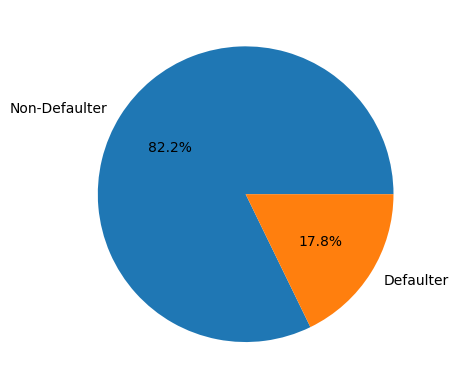

In [18]:
# check for target var proportion
r = train_data.groupby('Risk_Flag')['Risk_Flag'].count()
plt.pie(r, labels=['Non-Defaulter', 'Defaulter'], radius=1.0, autopct='%1.1f%%');

**Unbalance Data**

The label, i.e. Risk_flag column, is not evenly distributed and is likely to produce undesired outcome. To solve this issue, an oversampling method should be used:
1. **Random Over Sampling**: this method is easy to implement since, it will increase the dataset size simply by duplicating the original data points randomly
2. **SMOTE**: creates synthetic data points based on the original ones. Not only SMOTE increases dataset size, the variety will also be increased

### **Random Over Sampling**

In [19]:
random_sampler = RandomOverSampler(random_state=30)
X_oversampling, y_oversampling = random_sampler.fit_resample(X, y)

In [20]:
X_oh_oversampling = pd.get_dummies(X_oversampling)

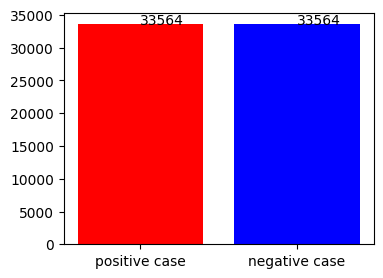

In [21]:
pos_samples = y_oversampling.value_counts()[1]
neg_samples = y_oversampling.value_counts()[0]
fig = plt.figure(figsize=(4, 3))

cases = ['positive case', 'negative case']
numbers = [pos_samples, neg_samples]
plt.bar(cases, numbers, color=['red', 'blue'])
for i, number in enumerate(numbers):
    plt.text(i, number, number)
plt.show()

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X_oh_oversampling, y_oversampling, train_size=0.8, test_size=0.2)

In [23]:
rf_model = RandomForestClassifier(n_estimators=250)
rf_model.fit(X_train, y_train)
acc_train = accuracy_score(y_valid, rf_model.predict(X_valid))
f1 = f1_score(y_valid, rf_model.predict(X_valid))
print('training_acc: {}'.format(acc_train))
print('f1 score: {}'.format(f1))

training_acc: 0.9839118129003426
f1 score: 0.9837054918527458


The result seems really good, lets hope the model performs well on the test set

In [24]:
X_test = test_data.drop(columns=['risk_flag'])
X_test = pd.get_dummies(X_test)
y_test = test_data['risk_flag']

In [25]:
acc_test = accuracy_score(y_test, rf_model.predict(X_test))
f1_test = f1_score(y_test, rf_model.predict(X_test))
print('testing_acc: {}'.format(acc_test))
print('f1 score: {}'.format(f1_test))

testing_acc: 0.9182489451476793
f1 score: 0.025157232704402514


### **Remarks**
* Again overall accuracy is good but the model still performs poorly with positive cases on the test set
* Let's try SMOTE instead of Random Over Sampling this time

### **SMOTE**

In [26]:
smote_sampler = SMOTENC(random_state=30, categorical_features=[3, 4, 5, 6, 7, 8])
X_smote, y_smote = smote_sampler.fit_resample(X, y)

In [27]:
X_oh_smote = pd.get_dummies(X_smote)

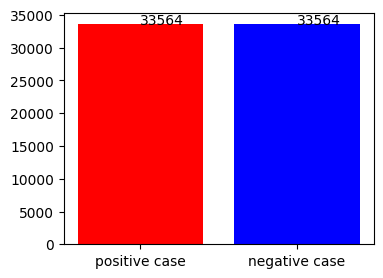

In [28]:
pos_samples = y_smote.value_counts()[1]
neg_samples = y_smote.value_counts()[0]
fig = plt.figure(figsize=(4, 3))

cases = ['positive case', 'negative case']
numbers = [pos_samples, neg_samples]
plt.bar(cases, numbers, color=['red', 'blue'])
for i, number in enumerate(numbers):
    plt.text(i, number, number)
plt.show()

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X_oh_smote, y_smote, train_size=0.8, test_size=0.2)

In [30]:
rf_model = RandomForestClassifier(n_estimators=250)
rf_model.fit(X_train, y_train)
acc_train = accuracy_score(y_valid, rf_model.predict(X_valid))
f1 = f1_score(y_valid, rf_model.predict(X_valid))
print('training_acc: {}'.format(acc_train))
print('f1 score: {}'.format(f1))

training_acc: 0.7285863250409653
f1 score: 0.7293925441853557


In [31]:
acc_test = accuracy_score(y_test, rf_model.predict(X_test))
f1_test = f1_score(y_test, rf_model.predict(X_test))
print('testing_acc: {}'.format(acc_test))
print('f1 score: {}'.format(f1_test))

testing_acc: 0.7792721518987342
f1 score: 0.13711340206185565


### **Remarks**
* This time the performance is not as good for the training set, but the model performs significantly better with positive cases on the test set
* The increase of the dataset in terms of variability provided by SMOTE clearly helps in this case.

## **Conclusion**

* A performance of a predictive ML model strongly depends on how well the datast is prepared
* Unbalanced data is a challenging problem, and the best way is usually to gather more data.
* For a temporary solution to unbalanced data, over sampling method like SMOTE can help in some cases.  